In [1]:
#define constants
QUBITS = 5
REPS = 1
SHOTS = 1000000

# Benchmarking libraries
!pip install qiskit_aer
!pip install qiskit_ibm_runtime
from typing import Any, Optional
import numpy as np
from qiskit import *
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit_aer import *
from qiskit_ibm_runtime import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


# Noise modeling libraries
from qiskit_aer.noise import (
    NoiseModel,
    depolarizing_error,
    thermal_relaxation_error,
)

class AdversarialBenchmark:
    """
    Class to generate and run a quantum adversarial benchmark on a given backend.
    """

    OPTIMIZATION_LEVEL = 0

    def __init__(
        self,
        num_qubits: int,
        repetitions: Optional[int] = None,
        backend: Any = None,
    ) -> None:
        """
        Initialize the AdversarialBenchmark.

        Parameters:
            num_qubits: Number of qubits in the quantum circuit.
            repetitions: Number of times to repeat the benchmark circuit. Defaults to num_qubits.
            backend: Backend simulator or quantum device to run the benchmark. Defaults to AerSimulator.
        """
        self.num_qubits = num_qubits
        self.repetitions = repetitions or self.num_qubits
        self.backend = backend or AerSimulator()
        self.circuit = self._generate_benchmark()

    def __call__(self, shots: int = 100) -> float:
        """
        Run the benchmark on the given backend.

        Parameters:
            shots: Number of shots to run the quantum circuit.

        Returns:
            Error rate of the quantum circuit on the given backend.
        """
        counts = self._run_circuit(self.circuit, shots=shots)
        return self._calculate_error(counts)

    def _generate_benchmark(self) -> QuantumCircuit:
        """
        Generate the benchmark quantum circuit.

        Parameters:
            num_qubits: Number of qubits in the quantum circuit.

        Returns:
            Gate instance of the benchmark.
        """
        benchmark = QuantumCircuit(self.num_qubits, self.num_qubits)
        for _ in range(self.repetitions):
            for i in range(self.num_qubits):
                # Permute the superposition state
                angle = 0 if i == 0 else np.pi * (i / (self.num_qubits - 1))
                benchmark.u(angle, angle, angle, i)
            self.gate = benchmark.copy()
            for i in range(self.num_qubits - 1):
                benchmark.cx(i, i + 1)
        return benchmark & benchmark.inverse()

    def _run_circuit(self, circuit: QuantumCircuit, shots: int) -> dict:
        """
        Run the given quantum circuit on the backend.

        Parameters:
            circuit: Quantum circuit to run.
            shots: Number of shots to run the quantum circuit.

        Returns:
            Counts of the quantum circuit results.
        """
        compiled_circuit = transpile(
            circuit, self.backend, optimization_level=self.OPTIMIZATION_LEVEL
        )
        compiled_circuit.measure_all()
 
        pm = generate_preset_pass_manager(backend = self.backend, optimization_level=3)
        isa_circuit = pm.run(compiled_circuit)
        isa_circuit.measure_all()
        with Session(backend = self.backend) as session:
            sampler = SamplerV2()
            job = sampler.run([isa_circuit], shots = 1024)
            print(job.result())
            counts = job.result()[0].data.c.get_counts()
        
        return counts

    @staticmethod
    def _calculate_error(counts: dict) -> float:
        """
        Calculate the error rate from the given counts.

        Parameters:
            counts: Counts of the quantum circuit results.

        Returns:
            Error rate.
        """
        total_counts = sum(counts.values())
        correct_counts = counts.get("0" * len(set(counts.keys()).pop()), 0)
        return 1 - correct_counts / total_counts



In [2]:
# Given parameters
one_qubit_fidelity = 0.99890
two_qubit_fidelity = 0.97680
T1 = 110  # seconds
T2 = 1.5  # seconds
one_qubit_gate_time = 135e-6  # seconds
two_qubit_gate_time = 600e-6  # seconds

# Compute depolarizing error probabilities
one_qubit_error_rate = 1 - one_qubit_fidelity
two_qubit_error_rate = 1 - two_qubit_fidelity

# Create depolarizing errors
one_qubit_depolarizing = depolarizing_error(one_qubit_error_rate, 1)
two_qubit_depolarizing = depolarizing_error(two_qubit_error_rate, 2)

# Create thermal relaxation errors
thermal_relaxation_one_qubit = thermal_relaxation_error(T1, T2, one_qubit_gate_time)
thermal_relaxation_two_qubit = thermal_relaxation_error(
    T1, T2, two_qubit_gate_time
).tensor(thermal_relaxation_error(T1, T2, two_qubit_gate_time))

# Construct the noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(one_qubit_depolarizing, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(two_qubit_depolarizing, ["cx"])
noise_model.add_all_qubit_quantum_error(
    thermal_relaxation_one_qubit, ["u1", "u2", "u3"]
)
noise_model.add_all_qubit_quantum_error(thermal_relaxation_two_qubit, ["cx"])

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'cx', 'u2', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3', 'cx']


In [3]:
#Load IBM sherbrooke as backend
QiskitRuntimeService.save_account(channel = 'ibm_quantum', token = 'b1fd1f131e04b72084414f2303dc765a6ea23c0b9f42aee5f6f5eea23aca0d375e9cdaed3a0d70f6cc5f209346bf4bb4dd06124a5bf2ab500beac7e17b1d7ec9',
                                  overwrite = True, set_as_default = True)
service = QiskitRuntimeService(instance = "ibm-q/open/main")
sherbrooke_backend = service.backend('ibm_sherbrooke')

# Create an instance of AdversarialBenchmark using the noisy simulator
benchmark = AdversarialBenchmark(
    num_qubits=QUBITS,
    repetitions=REPS,
    backend=sherbrooke_backend,
)

# Show the benchmark circuit
benchmark.circuit.draw()

┌──────────┐                                            »
q_0: ─────┤ U(0,0,0) ├──────■─────────────────────────────────────»
       ┌──┴──────────┴──┐ ┌─┴─┐                                   »
q_1: ──┤ U(π/4,π/4,π/4) ├─┤ X ├──■────────────────────────────────»
       ├────────────────┤ └───┘┌─┴─┐                              »
q_2: ──┤ U(π/2,π/2,π/2) ├──────┤ X ├──■───────────────────■───────»
     ┌─┴────────────────┴┐     └───┘┌─┴─┐               ┌─┴─┐     »
q_3: ┤ U(3π/4,3π/4,3π/4) ├──────────┤ X ├──■────■───────┤ X ├─────»
     └────┬──────────┬───┘          └───┘┌─┴─┐┌─┴─┐┌────┴───┴────┐»
q_4: ─────┤ U(π,π,π) ├───────────────────┤ X ├┤ X ├┤ U(-π,-π,-π) ├»
          └──────────┘                   └───┘└───┘└─────────────┘»
c: 5/═════════════════════════════════════════════════════════════»
                                                                  »
«                                                       ┌──────────┐    
«q_0: ──────────────────────────────────■───────────────┤ U(0,0,0) ├────
«                                     ┌─┴─┐        ┌────┴──────────┴───┐
«q_1: ───────────■────────────────────┤ X ├────────┤ U(-π/4,-π/4,-π/4) ├
«              ┌─┴─┐          ┌───────┴───┴───────┐└───────────────────┘
«q_2: ─────────┤ X ├──────────┤ U(-π/2,-π/2,-π/2) ├─────────────────────
«     ┌────────┴───┴─────────┐└───────────────────┘                     
«q_3: ┤ U(-3π/4,-3π/4,-3π/4) ├──────────────────────────────────────────
«     └──────────────────────┘                                          
«q_4: ──────────────────────────────────────────────────────────────────
«                                                                       
«c: 5/══════════════════════════════════════════════════════════════════
«

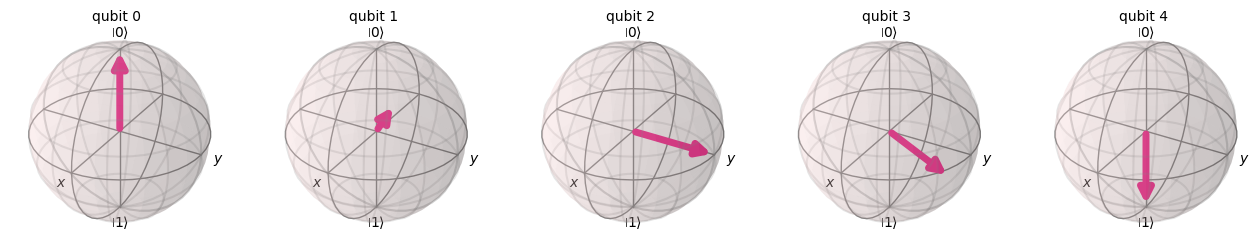

In [4]:
# Create a statevector from the circuit
state = Statevector.from_instruction(benchmark.gate)

# Plot the Bloch spheres
plot_bloch_multivector(state)

In [5]:
# Run the benchmark and measure the error
error = benchmark(shots=SHOTS)
print(f"Error rate: {error:.7%}")

PrimitiveResult([PubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=5>), meas=BitArray(<shape=(), num_shots=1024, num_bits=127>), meas0=BitArray(<shape=(), num_shots=1024, num_bits=127>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([SliceSpan(<start='2024-10-12 10:10:36', stop='2024-10-12 10:11:23', size=1024>)])}, 'version': 2})
Error rate: 0.00000%
